In [ ]:
import xarray as xr
import numpy as np
import s3fs
# import cfgrib
import matplotlib.pyplot as plt

In [23]:
dir_name = 'D:/crs/proj/2024_ESTOFS'
date_list = ['20210926', '20210927', '20210928']
wl_list = ['cwl', 'htp', 'swl']
tz_list = ['t00z', 't06z', 't12z', 't18z']

In [ ]:
flist = []
for date in date_list:
    for tz in tz_list:
        flist.append( f"{dir_name}/{date}/estofs.{tz}.conus.east.{wl_list[2]}.grib2" )

print(flist)

# Open the GRIB2 file with xarray and cfgrib engine
ds = xr.open_dataset( flist[0], engine = 'cfgrib' )

# Print dataset info to inspect
ds

['D:/crs/proj/2024_ESTOFS/20210926/estofs.t00z.conus.east.swl.grib2', 'D:/crs/proj/2024_ESTOFS/20210926/estofs.t06z.conus.east.swl.grib2', 'D:/crs/proj/2024_ESTOFS/20210926/estofs.t12z.conus.east.swl.grib2', 'D:/crs/proj/2024_ESTOFS/20210926/estofs.t18z.conus.east.swl.grib2']


<xarray.Dataset> Size: 2GB
Dimensions:     (step: 181, y: 1377, x: 2145)
Coordinates:
    time        datetime64[ns] 8B ...
  * step        (step) timedelta64[ns] 1kB 00:00:00 01:00:00 ... 7 days 12:00:00
    surface     float64 8B ...
    latitude    (y, x) float64 24MB ...
    longitude   (y, x) float64 24MB ...
    valid_time  (step) datetime64[ns] 1kB ...
Dimensions without coordinates: y, x
Data variables:
    etsrg       (step, y, x) float32 2GB ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          4
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2024-10-03T17:58 GRIB to CDM+CF via cfgrib-0.9.1...

In [13]:
# Find the closest grid point
lats = ds['latitude'].values
lons = ds['longitude'].values

latt = 35.716
lont = 360-75.4937

# Calculate the difference between the grid points and the target location
distance = np.sqrt((lats - latt)**2 + (lons - lont)**2)

# Find the index of the minimum distance (closest grid point)
min_index_flat = np.argmin(distance)

# Convert the flat index to row and column indices
min_index_2d = np.unravel_index(min_index_flat, distance.shape)
print(min_index_2d)

(np.int64(627), np.int64(1792))


In [14]:
t = ds.time.values
ts = t+ds.step.values
z = ds.etsrg[:,627,1792].values

(array([18896.  , 18896.25, 18896.5 , 18896.75, 18897.  , 18897.25,
        18897.5 , 18897.75, 18898.  ]),
 [Text(18896.0, 0, '09-26 00'),
  Text(18896.25, 0, '09-26 06'),
  Text(18896.5, 0, '09-26 12'),
  Text(18896.75, 0, '09-26 18'),
  Text(18897.0, 0, '09-27 00'),
  Text(18897.25, 0, '09-27 06'),
  Text(18897.5, 0, '09-27 12'),
  Text(18897.75, 0, '09-27 18'),
  Text(18898.0, 0, '09-28 00')])

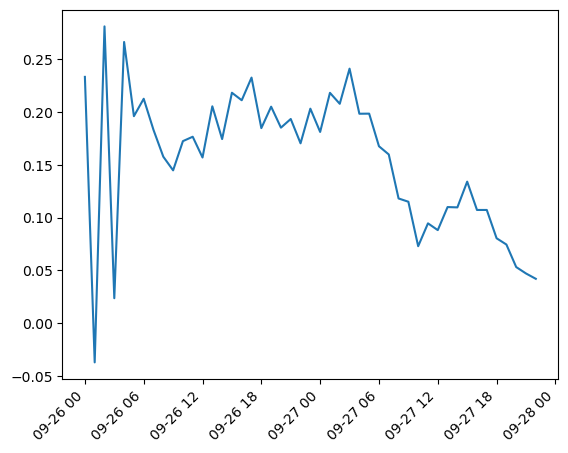

In [15]:
plt.plot(ts[0:47],z[0:47])
plt.xticks(rotation=45, ha='right')

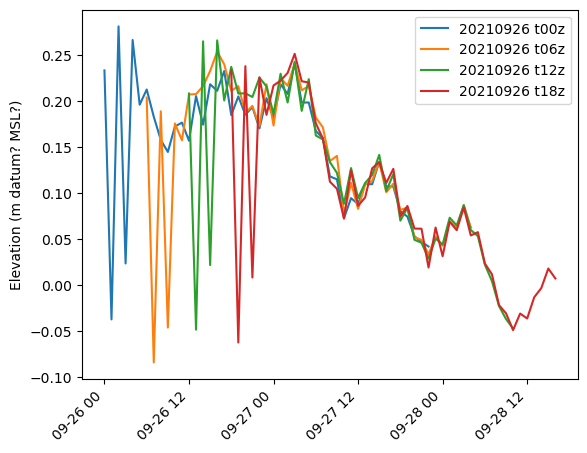

In [19]:
# Open the GRIB2 file with xarray and cfgrib engine
fig, ax = plt.subplots(1,1)

for date in date_list:
    for tz in tz_list:
        fname =  f"{dir_name}/{date}/estofs.{tz}.conus.east.{wl_list[2]}.grib2" 
        flabel = f"{date} {tz}"
        ds = xr.open_dataset( fname, engine = 'cfgrib' )
        t = ds.time.values
        ts = t+ds.step.values
        z = ds.etsrg[:,627,1792].values
        plt.plot(ts[0:47],z[0:47],label=flabel)

plt.legend()
plt.xticks(rotation=45, ha='right')
plt.ylabel('Elevation (m datum? MSL?)')
plt.savefig(dir_name+'/ESTOF_surge_elevations_multi_forecast.png', bbox_inches='tight', dpi=200)

AttributeError: 'NoneType' object has no attribute 'append'

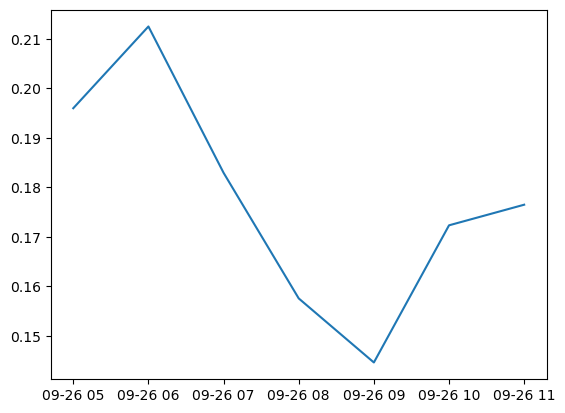

In [25]:
# Open the GRIB2 file with xarray and cfgrib engine
fig, ax = plt.subplots(1,1)

tlong = []
zlong = []
for date in date_list:
    for tz in tz_list:
        fname =  f"{dir_name}/{date}/estofs.{tz}.conus.east.{wl_list[2]}.grib2" 
        flabel = f"{date} {tz}"
        ds = xr.open_dataset( fname, engine = 'cfgrib' )
        t = ds.time.values
        ts = t+ds.step.values
        z = ds.etsrg[:,627,1792].values
        tshort = ts[5:12]
        zshort = z[5:12]
        tlong = tlong.append(tshort)
        zlong = zlong.append(zlong)
        plt.plot(tshort,zshort,label=flabel)

plt.legend()
plt.plot(tlong, zlong, '.k',label='Nowcast')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Elevation (m datum? MSL?)')
plt.savefig(dir_name+'/ESTOF_surge_elevations_nowcast_forecast.png', bbox_inches='tight', dpi=200)